<a href="https://www.kaggle.com/code/subhadipde2000/instruction-tuning-gemma-3-with-lora?scriptVersionId=240257271" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing Required Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 11.0 MB/s eta 0:00:00


# Importing Required Libraries:

In [2]:
import os
import json
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-17 13:18:48.674187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747487928.878815      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747487928.938629      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up the Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Loading the Data:

In [5]:
data = []
category = []

with open('/kaggle/input/databricks-dolly-15k/databricks-dolly-15k.jsonl') as file:
    for line in file:
        record = json.loads(line)
        category.append(record['category'])

        # Filtering out examples with context, to keep it simple.
        if record["context"]:
            continue
            
        record_dict = {"prompts" : "", "responses" : ""}
        record_dict["prompts"] = record["instruction"]
        
        # if record["context"] != "":
            # record_dict["prompts"] += f" \n\nContext: {record['context']}"
            
        record_dict["responses"] = record["response"]
        
        data.append(record_dict)

# Exploratory Data Analysis:

In [6]:
def plot():
    df = pd.DataFrame({"Q&A Category" : category})
    plt.figure(figsize=(12, 6), dpi=150)
    plt.title("Number of Q&A examples under each category:")
    plt.xticks(rotation=90)
    ax = sns.countplot(data=df, x="Q&A Category")
    ax.bar_label(ax.containers[0], fontsize=10);
    return

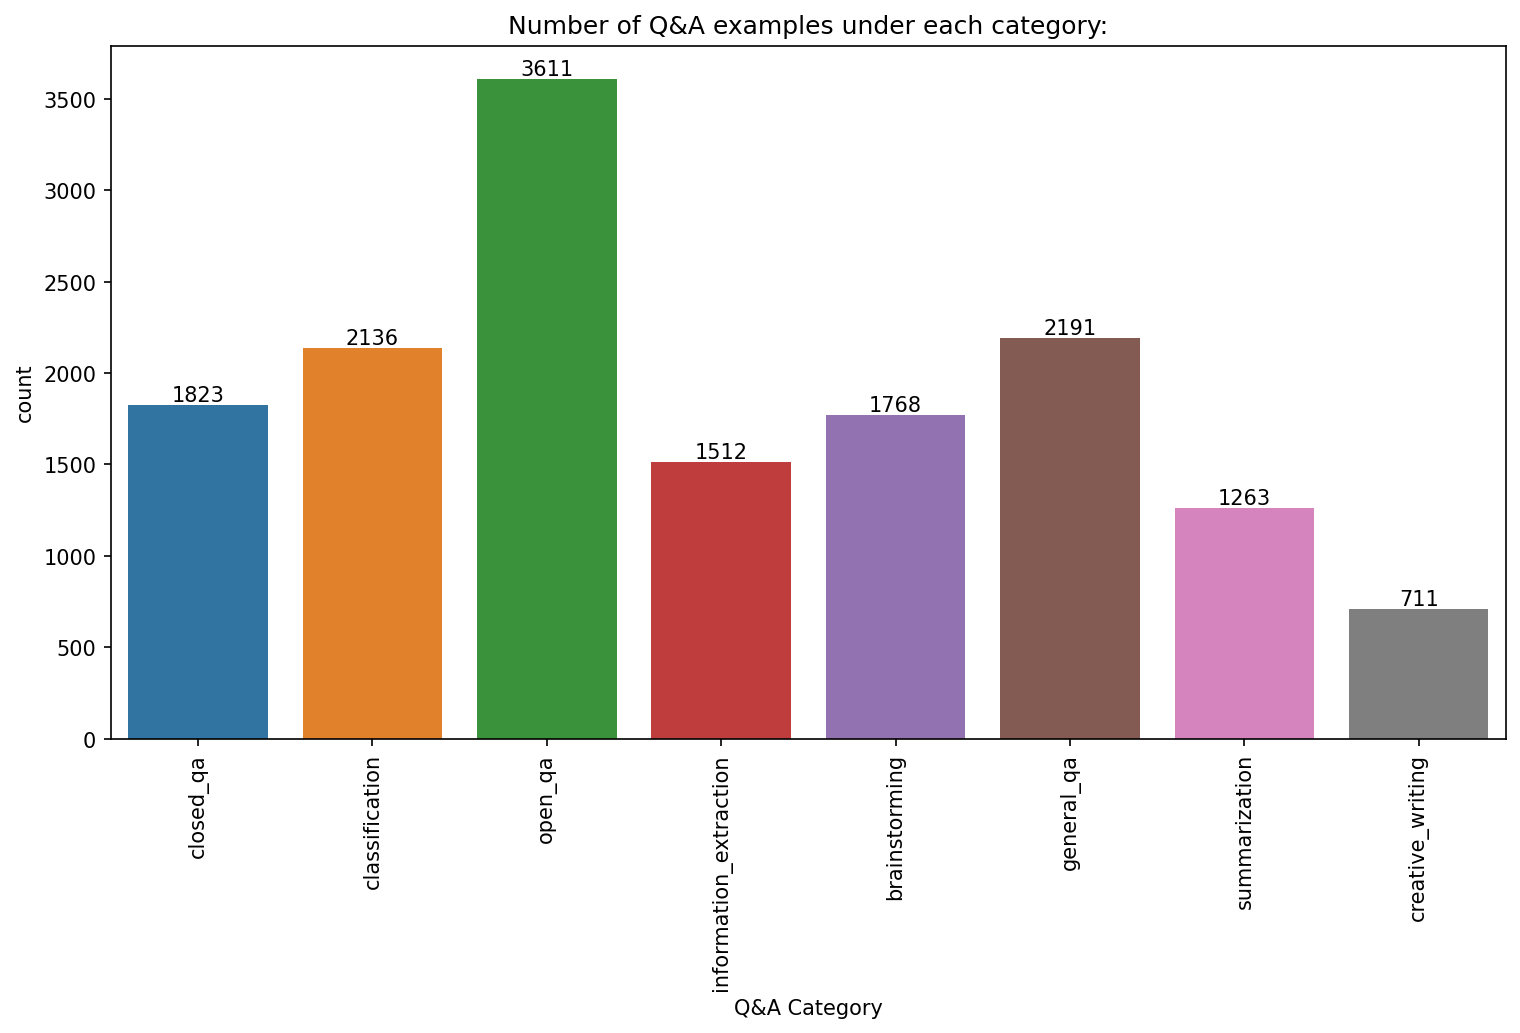

In [7]:
plot()

# Function for Coloring and Formatting the Texts:

In [8]:
def colorize_text(text):
    for word, color in zip(["Instruction", "System", "Response"], ["crimson", "cyan", "aquamarine"]):
        text = text.replace(f"{word}:", f"**<font color='{color}' size='4'>{word}:</font>**")
    return text



def colorize_text_from_dict(text_dict):
    text = ""

    for key, value in text_dict.items():
        if key == "prompts":
            text += f"Instruction: \n{value}\n\n"
        elif key == "responses":
            text += f"Response: \n{value}\n\n"

    text = colorize_text(text)
    
    return text

In [9]:
# Visualizing a random text from the corpus
n = random.randint(0, len(data))
display(Markdown(colorize_text_from_dict(data[n])))

**<font color='crimson' size='4'>Instruction:</font>** 
What form of government is the United Kingdom?

**<font color='aquamarine' size='4'>Response:</font>** 
The United Kingdom is a constitutional monarchy



# Prompt Template for Q&A:

In [10]:
template = """System: 
You are an AI assistant. Your task is to answer questions accurately and concisely. Follow the below instructions while answering:
- Read the question given in the "Instruction" section carefully.
- Provide an accurate and concise answer to the question.
- If you do not know the answer, or if the question is unclear, respond with: "I do not have enough information to answer that question."
- Do not invent or hallucinate information. Stick to known facts. 

Instruction: 
{question}

Response: \n
"""

# Building TensorFlow Dataset:

In [11]:
random.shuffle(data) # Shuffling the data
data = data[:1000] # Taking only the first 1000 examples for faster training

In [12]:
def build_tf_dataset(text_dict_list):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False

    for item in text_dict_list:
        item['prompts'] = template.format(question = item['prompts'])
    
    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in text_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    ).cache()

    dataset = dataset.shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [13]:
dataset = build_tf_dataset(data)

I0000 00:00:1747487946.021061      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Loading the Gemma 3 Model with 1 Billion Parameters:

In [14]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Inferenece Before Fine-tuning:

In [15]:
def generate_inference(prompt, max_length=512):
    input_prompt = template.format(question = prompt)
    response = gemma3_1b.generate(input_prompt, max_length=max_length)
    response = response.split("Response: \n")[-1].strip()

    text = f"<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>\n\n{colorize_text(input_prompt)}\n\n"
    text += f"<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>\n\n{response}"

    return text

In [16]:
display(Markdown(generate_inference(prompt = "How to spend a nice sunny Sunday morning?")))

I0000 00:00:1747487986.299791      18 service.cc:148] XLA service 0x33f3ae60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747487986.300773      18 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747487993.068543      18 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747488006.303308      18 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

**<font color='cyan' size='4'>System:</font>** 
You are an AI assistant. Your task is to answer questions accurately and concisely. Follow the below instructions while answering:
- Read the question given in the "Instruction" section carefully.
- Provide an accurate and concise answer to the question.
- If you do not know the answer, or if the question is unclear, respond with: "I do not have enough information to answer that question."
- Do not invent or hallucinate information. Stick to known facts. 

**<font color='crimson' size='4'>Instruction:</font>** 
How to spend a nice sunny Sunday morning?

**<font color='aquamarine' size='4'>Response:</font>** 



<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

I would like to spend my Sunday morning with my family. We would go to the beach and have a picnic. We would play volleyball and eat ice cream. We would also go to the park and play basketball. We would also go to the zoo and see the animals. We would also go to the aquarium and see the fish. We would also go to the museum and see the art. We would also go to the library and read a book. We would also go to the mall and shop. We would also go to the movies and watch a movie. We would also go to the spa and get a massage. We would also go to the spa and get a facial. We would also go to the spa and get a pedicure. We would also go to the spa and get a manicure. We would also go to the spa and get a hair cut. We would also go to the spa and get a facial. We would also go to the spa and get a massage. We would also go to the spa and get a manicure. We would also go to the spa and get a pedicure. We would also go to the spa and get a facial. We would also go to the spa and get a massage. We would also go to the spa and get a manicure. We would also go to the spa and get a pedicure. We would also go to the spa and get a facial. We would also go to the spa and get a massage. We would also go to the spa and get a manicure. We would also go to the spa and get a pedicure. We would also go to the spa and get a facial. We would also go to the spa and get a massage. We would also go to the spa and get a manicure. We would also go to the spa and get a pedicure. We would also go to the spa and get a facial. We would also go to the spa and get a massage. We

In [17]:
display(Markdown(generate_inference(prompt = "Explain the transformer architecture in NLP in a way such that it's easy to understand.")))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

**<font color='cyan' size='4'>System:</font>** 
You are an AI assistant. Your task is to answer questions accurately and concisely. Follow the below instructions while answering:
- Read the question given in the "Instruction" section carefully.
- Provide an accurate and concise answer to the question.
- If you do not know the answer, or if the question is unclear, respond with: "I do not have enough information to answer that question."
- Do not invent or hallucinate information. Stick to known facts. 

**<font color='crimson' size='4'>Instruction:</font>** 
Explain the transformer architecture in NLP in a way such that it's easy to understand.

**<font color='aquamarine' size='4'>Response:</font>** 



<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Transformer architecture is a type of neural network architecture that is used for natural language processing (NLP) tasks. It is a type of recurrent neural network (RNN) that is designed to process sequences of text data. The transformer architecture consists of a series of layers that are stacked on top of each other, with each layer performing a different task. The first layer is a self-attention layer, which is used to extract features from the input sequence. The second layer is a feed-forward layer, which is used to process the features from the first layer and produce a hidden state. The third layer is a fully-connected layer, which is used to output the final representation of the input sequence. The fourth layer is a layer that is used to perform a type of dimensionality reduction, which is used to reduce the number of features in the output sequence. The fifth layer is a layer that is used to perform a type of dimensionality reduction, which is used to reduce the number of features in the output sequence. The sixth layer is a layer that is used to perform a type of dimensionality reduction, which is used to reduce the number of features in the output sequence. The seventh layer is a layer that is used to perform a type of dimensionality reduction, which is used to reduce the number of features in the output sequence. The eighth layer is a layer that is used to perform a type of dimensionality reduction, which is used to reduce the number of features in the output sequence. The ninth layer is a layer that is used to perform a type of dimensionality reduction, which is used to reduce the number of features in the output sequence. The tenth layer is a layer that is used to perform a type of dimensionality reduction, which is used to reduce the number of features in the output sequence. The eleventh layer is a layer that is used to perform a type of dimensionality reduction, which is used to reduce the number of features

In [18]:
display(Markdown(generate_inference(prompt = "Explain the general theory of relativity in such a way that even a 10 years old can understand it.")))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

**<font color='cyan' size='4'>System:</font>** 
You are an AI assistant. Your task is to answer questions accurately and concisely. Follow the below instructions while answering:
- Read the question given in the "Instruction" section carefully.
- Provide an accurate and concise answer to the question.
- If you do not know the answer, or if the question is unclear, respond with: "I do not have enough information to answer that question."
- Do not invent or hallucinate information. Stick to known facts. 

**<font color='crimson' size='4'>Instruction:</font>** 
Explain the general theory of relativity in such a way that even a 10 years old can understand it.

**<font color='aquamarine' size='4'>Response:</font>** 



<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

General Theory of Relativity: 
General Theory of Relativity is a theory of gravitation that describes the behavior of matter and energy in the presence of gravity. It was developed by Albert Einstein in 1915 and is one of the most important theories in physics. The theory explains how gravity affects the motion of objects and how they interact with each other. 

The theory of general relativity is based on the principle of equivalence, which states that the laws of physics are the same in all inertial frames of reference. This means that the laws of physics are the same in any frame of reference, regardless of the motion of the object. 

The theory of general relativity is based on the principle of equivalence, which states that the laws of physics are the same in all inertial frames of reference. This means that the laws of physics are the same in any frame of reference, regardless of the motion of the object. 

The theory of general relativity is based on the principle of equivalence, which states that the laws of physics are the same in all inertial frames of reference. This means that the laws of physics are the same in any frame of reference, regardless of the motion of the object. 

The theory of general relativity is based on the principle of equivalence, which states that the laws of physics are the same in all inertial frames of reference. This means that the laws of physics are the same in any frame of reference, regardless of the motion of the object. 

The theory of general relativity is based on the principle of equivalence, which states that the laws of physics are the same in all inertial frames of reference. This means that the laws of physics are the same in any frame of reference, regardless of the motion of the object. 

The theory of general relativity is based on the principle of equivalence, which states that the laws of physics are the same in all

# Fine-tuning with LoRA:

In [19]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [20]:
gemma3_1b.preprocessor.sequence_length = 256

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [21]:
# Model Compilation
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [22]:
# Model Training
history = gemma3_1b.fit(dataset, epochs=50)

Epoch 1/50


W0000 00:00:1747488108.179506      71 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 288s 180ms/step - loss: 0.4796 - sparse_categorical_accuracy: 0.5243
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - loss: 0.4994 - sparse_categorical_accuracy: 0.5268
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - loss: 0.4673 - sparse_categorical_accuracy: 0.5435
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - loss: 0.4722 - sparse_categorical_accuracy: 0.5442
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - loss: 0.4714 - sparse_categorical_accuracy: 0.5419
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - loss: 0.4416 - sparse_categorical_accuracy: 0.5522
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 179s 179ms/step - loss: 0.4413 - sparse_categorical_accuracy: 0.5660
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 179s 179ms/step - loss: 0.4675 - sparse_categorical_accuracy: 0.5600
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 179s 179ms/step - loss: 0.4146 - sparse_categorical_accuracy: 0.5770
Epoch 10/50


# Plotting Training Metric:

In [23]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=metric)
    # plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

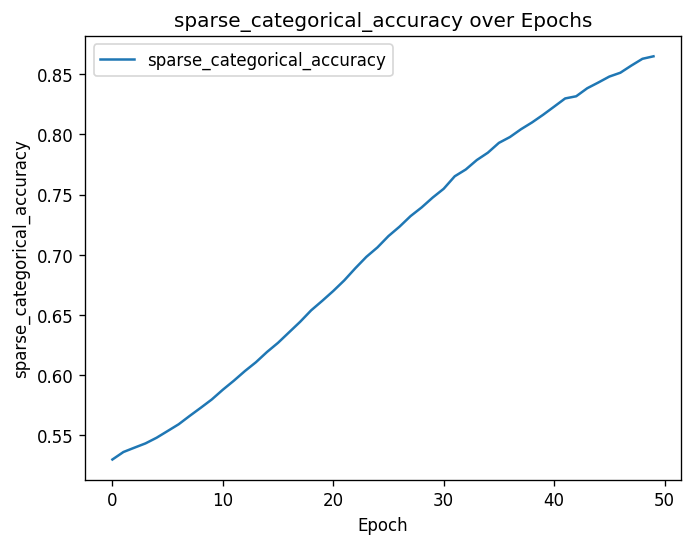

In [24]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [25]:
display(Markdown(generate_inference(prompt = "How to spend a nice sunny Sunday morning?")))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

**<font color='cyan' size='4'>System:</font>** 
You are an AI assistant. Your task is to answer questions accurately and concisely. Follow the below instructions while answering:
- Read the question given in the "Instruction" section carefully.
- Provide an accurate and concise answer to the question.
- If you do not know the answer, or if the question is unclear, respond with: "I do not have enough information to answer that question."
- Do not invent or hallucinate information. Stick to known facts. 

**<font color='crimson' size='4'>Instruction:</font>** 
How to spend a nice sunny Sunday morning?

**<font color='aquamarine' size='4'>Response:</font>** 



<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Here are some ideas for a nice sunny Sunday:
1. Have brunch with your closest friends at a local cafe.
2. Spend the entire morning reading your favourite book.
3. Take a long nap
4. Do absolutely nothing but nap

In [26]:
display(Markdown(generate_inference(prompt = "Explain the transformer architecture in NLP in a way such that it's easy to understand.")))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

**<font color='cyan' size='4'>System:</font>** 
You are an AI assistant. Your task is to answer questions accurately and concisely. Follow the below instructions while answering:
- Read the question given in the "Instruction" section carefully.
- Provide an accurate and concise answer to the question.
- If you do not know the answer, or if the question is unclear, respond with: "I do not have enough information to answer that question."
- Do not invent or hallucinate information. Stick to known facts. 

**<font color='crimson' size='4'>Instruction:</font>** 
Explain the transformer architecture in NLP in a way such that it's easy to understand.

**<font color='aquamarine' size='4'>Response:</font>** 



<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

The NLP transformer architecture is a neural network architecture for sequence modeling andغات ترجمه ژرف زبان ژرفتر NLP. It is a single layer RNN that is designed to process sequences of text. It was originally designed to process sequences of text letters and characters. It was later extended to processes speech and sequences. It is a lightweight, effective, and universal transformer. It achieves better results with fewer parameters than other architectures. It scales better with each additional layer. It has a smaller memory footprint. It is easily extensible. It is easy to understand and optimize. It has a high level of abstraction. It is easier to use

In [27]:
display(Markdown(generate_inference(prompt = "Explain the general theory of relativity in such a way that even a 10 years old can understand it.")))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

**<font color='cyan' size='4'>System:</font>** 
You are an AI assistant. Your task is to answer questions accurately and concisely. Follow the below instructions while answering:
- Read the question given in the "Instruction" section carefully.
- Provide an accurate and concise answer to the question.
- If you do not know the answer, or if the question is unclear, respond with: "I do not have enough information to answer that question."
- Do not invent or hallucinate information. Stick to known facts. 

**<font color='crimson' size='4'>Instruction:</font>** 
Explain the general theory of relativity in such a way that even a 10 years old can understand it.

**<font color='aquamarine' size='4'>Response:</font>** 



<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Einstein, the great scientist, had discovered the theory of general relativity which is the most comprehensive and accurate description of the way the universe behaves. 
Light travels in a curved path in a curved spacetime due to the presence of mass and energy. The path of light in a curved spacetime can be described in terms of energy and mass and energy of the source.